# Assignment1: Graph Embedding

Graph embedding aims to map each node in a given graph into a low-dimensional vector representation. By looking at nodes in the embedding space, we are able to mining information such as data clusters and links between nodes. \
In this assignment, we are focusing on the task of node clustering. First, you will answer 2 questions regarding traditional graph features. Second, you will implement DeepWalk, an automatic feature learning method that preserves graph structural information. At last, you will apply learned embeddings to clustering tasks and visualize the embeddings. \
Please follow the instructions below, filling in codes snippets and answering questions.

## Environment

In [17]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.cluster import KMeans

## Graph setup

In this assignment, we use character relationship graph from the book *Les Miserables* by *Victor Hugo*.
Nodes in this graph correspond to 77 characters, while edges indicate the co-occurrance of two characters in the novel. 

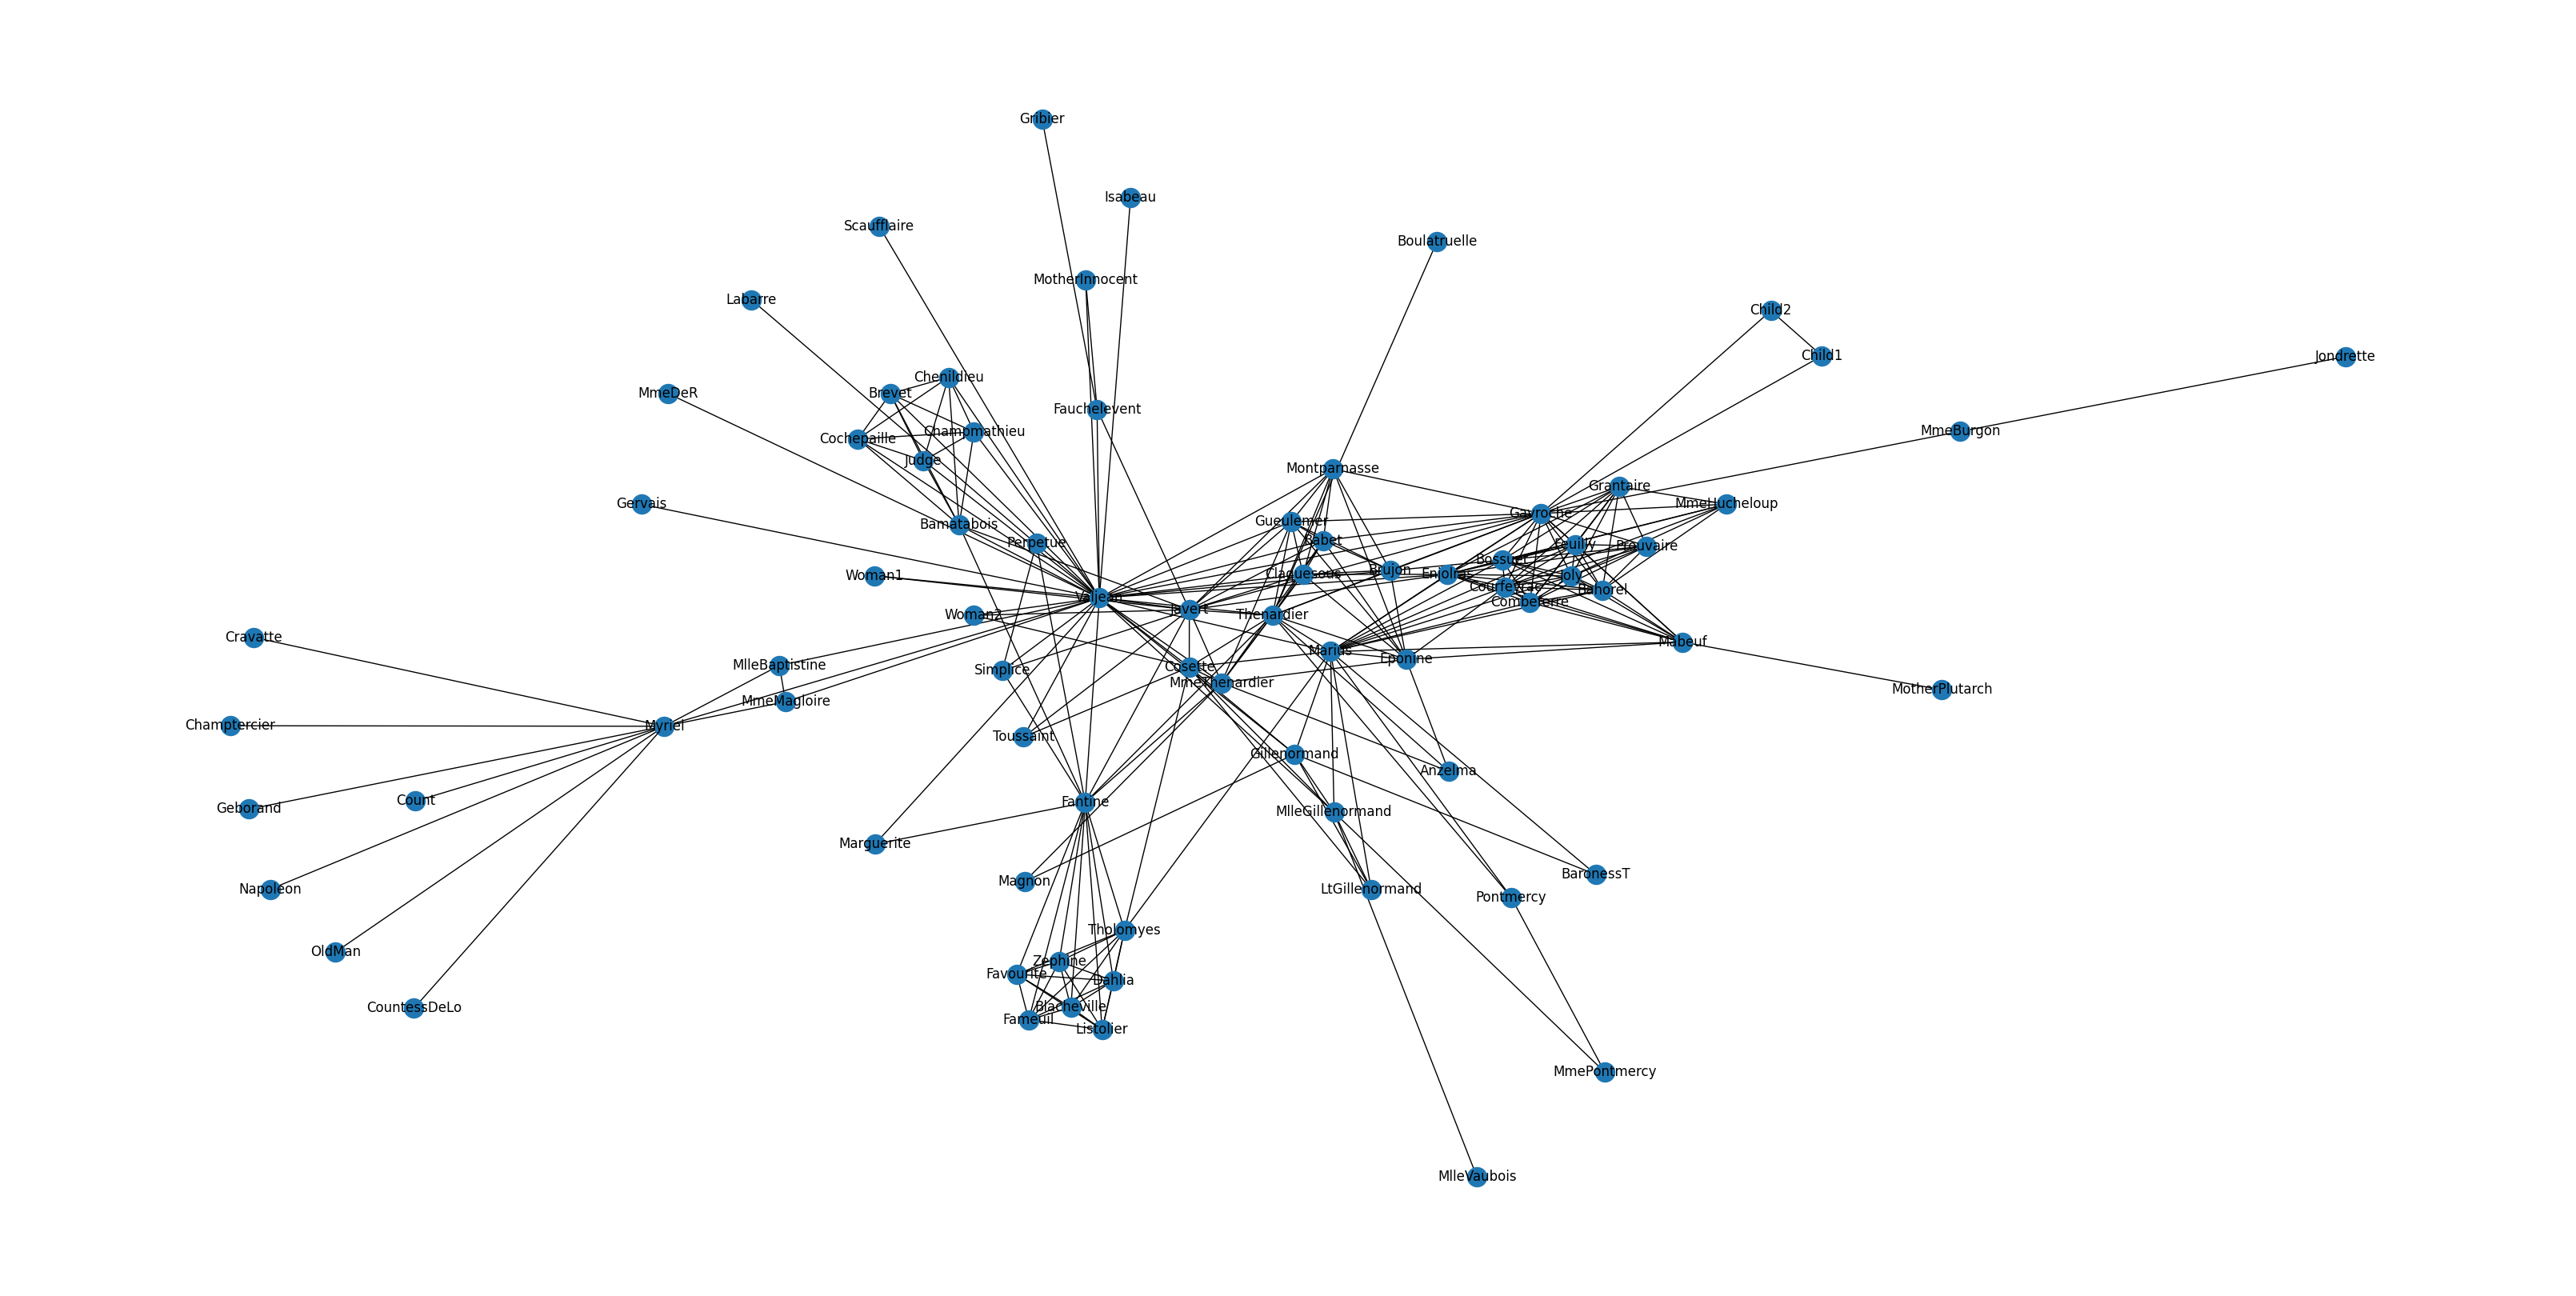

In [18]:
G = nx.les_miserables_graph()
# visualize graph
plt.figure(figsize=(32,16))
nx.draw(G, with_labels = True)

In [19]:
G.nodes

NodeView(('Napoleon', 'Myriel', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan', 'Valjean', 'Labarre', 'Marguerite', 'MmeDeR', 'Isabeau', 'Gervais', 'Listolier', 'Tholomyes', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'MmeThenardier', 'Thenardier', 'Cosette', 'Javert', 'Fauchelevent', 'Bamatabois', 'Perpetue', 'Simplice', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Pontmercy', 'Boulatruelle', 'Eponine', 'Anzelma', 'Woman2', 'MotherInnocent', 'Gribier', 'MmeBurgon', 'Jondrette', 'Gavroche', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Toussaint', 'Child1', 'Child2', 'Brujon', 'MmeHucheloup'))

In [20]:
G.edges(data=True)

EdgeDataView([('Napoleon', 'Myriel', {'weight': 1}), ('Myriel', 'MlleBaptistine', {'weight': 8}), ('Myriel', 'MmeMagloire', {'weight': 10}), ('Myriel', 'CountessDeLo', {'weight': 1}), ('Myriel', 'Geborand', {'weight': 1}), ('Myriel', 'Champtercier', {'weight': 1}), ('Myriel', 'Cravatte', {'weight': 1}), ('Myriel', 'Count', {'weight': 2}), ('Myriel', 'OldMan', {'weight': 1}), ('Myriel', 'Valjean', {'weight': 5}), ('MlleBaptistine', 'MmeMagloire', {'weight': 6}), ('MlleBaptistine', 'Valjean', {'weight': 3}), ('MmeMagloire', 'Valjean', {'weight': 3}), ('Valjean', 'Labarre', {'weight': 1}), ('Valjean', 'Marguerite', {'weight': 1}), ('Valjean', 'MmeDeR', {'weight': 1}), ('Valjean', 'Isabeau', {'weight': 1}), ('Valjean', 'Gervais', {'weight': 1}), ('Valjean', 'Fantine', {'weight': 9}), ('Valjean', 'MmeThenardier', {'weight': 7}), ('Valjean', 'Thenardier', {'weight': 12}), ('Valjean', 'Cosette', {'weight': 31}), ('Valjean', 'Javert', {'weight': 17}), ('Valjean', 'Fauchelevent', {'weight': 8})

The *Les Miserables* graph has weighted edges. For convenience, we will only use the graph topology, and set edge weights all equal to 1.

In [21]:
for u, v, d in G.edges(data=True):
    d['weight'] = 1

In [22]:
G.edges(data=True)

EdgeDataView([('Napoleon', 'Myriel', {'weight': 1}), ('Myriel', 'MlleBaptistine', {'weight': 1}), ('Myriel', 'MmeMagloire', {'weight': 1}), ('Myriel', 'CountessDeLo', {'weight': 1}), ('Myriel', 'Geborand', {'weight': 1}), ('Myriel', 'Champtercier', {'weight': 1}), ('Myriel', 'Cravatte', {'weight': 1}), ('Myriel', 'Count', {'weight': 1}), ('Myriel', 'OldMan', {'weight': 1}), ('Myriel', 'Valjean', {'weight': 1}), ('MlleBaptistine', 'MmeMagloire', {'weight': 1}), ('MlleBaptistine', 'Valjean', {'weight': 1}), ('MmeMagloire', 'Valjean', {'weight': 1}), ('Valjean', 'Labarre', {'weight': 1}), ('Valjean', 'Marguerite', {'weight': 1}), ('Valjean', 'MmeDeR', {'weight': 1}), ('Valjean', 'Isabeau', {'weight': 1}), ('Valjean', 'Gervais', {'weight': 1}), ('Valjean', 'Fantine', {'weight': 1}), ('Valjean', 'MmeThenardier', {'weight': 1}), ('Valjean', 'Thenardier', {'weight': 1}), ('Valjean', 'Cosette', {'weight': 1}), ('Valjean', 'Javert', {'weight': 1}), ('Valjean', 'Fauchelevent', {'weight': 1}), ('

Since node is marked by string form name in this graph, we should first tokenize nodes to indexs. You might use this function in later tasks.

In [23]:
def tokenize(G):
    nodes_list = list(G.nodes)
    name2id = {v: idx for idx, v in enumerate(G.nodes)}
    id2name = {idx: v for idx, v in enumerate(G.nodes)}
    return name2id, id2name

In [24]:
name2id, id2name = tokenize(G)

In [25]:
name2id

{'Napoleon': 0,
 'Myriel': 1,
 'MlleBaptistine': 2,
 'MmeMagloire': 3,
 'CountessDeLo': 4,
 'Geborand': 5,
 'Champtercier': 6,
 'Cravatte': 7,
 'Count': 8,
 'OldMan': 9,
 'Valjean': 10,
 'Labarre': 11,
 'Marguerite': 12,
 'MmeDeR': 13,
 'Isabeau': 14,
 'Gervais': 15,
 'Listolier': 16,
 'Tholomyes': 17,
 'Fameuil': 18,
 'Blacheville': 19,
 'Favourite': 20,
 'Dahlia': 21,
 'Zephine': 22,
 'Fantine': 23,
 'MmeThenardier': 24,
 'Thenardier': 25,
 'Cosette': 26,
 'Javert': 27,
 'Fauchelevent': 28,
 'Bamatabois': 29,
 'Perpetue': 30,
 'Simplice': 31,
 'Scaufflaire': 32,
 'Woman1': 33,
 'Judge': 34,
 'Champmathieu': 35,
 'Brevet': 36,
 'Chenildieu': 37,
 'Cochepaille': 38,
 'Pontmercy': 39,
 'Boulatruelle': 40,
 'Eponine': 41,
 'Anzelma': 42,
 'Woman2': 43,
 'MotherInnocent': 44,
 'Gribier': 45,
 'MmeBurgon': 46,
 'Jondrette': 47,
 'Gavroche': 48,
 'Gillenormand': 49,
 'Magnon': 50,
 'MlleGillenormand': 51,
 'MmePontmercy': 52,
 'MlleVaubois': 53,
 'LtGillenormand': 54,
 'Marius': 55,
 'Baron

In [26]:
id2name

{0: 'Napoleon',
 1: 'Myriel',
 2: 'MlleBaptistine',
 3: 'MmeMagloire',
 4: 'CountessDeLo',
 5: 'Geborand',
 6: 'Champtercier',
 7: 'Cravatte',
 8: 'Count',
 9: 'OldMan',
 10: 'Valjean',
 11: 'Labarre',
 12: 'Marguerite',
 13: 'MmeDeR',
 14: 'Isabeau',
 15: 'Gervais',
 16: 'Listolier',
 17: 'Tholomyes',
 18: 'Fameuil',
 19: 'Blacheville',
 20: 'Favourite',
 21: 'Dahlia',
 22: 'Zephine',
 23: 'Fantine',
 24: 'MmeThenardier',
 25: 'Thenardier',
 26: 'Cosette',
 27: 'Javert',
 28: 'Fauchelevent',
 29: 'Bamatabois',
 30: 'Perpetue',
 31: 'Simplice',
 32: 'Scaufflaire',
 33: 'Woman1',
 34: 'Judge',
 35: 'Champmathieu',
 36: 'Brevet',
 37: 'Chenildieu',
 38: 'Cochepaille',
 39: 'Pontmercy',
 40: 'Boulatruelle',
 41: 'Eponine',
 42: 'Anzelma',
 43: 'Woman2',
 44: 'MotherInnocent',
 45: 'Gribier',
 46: 'MmeBurgon',
 47: 'Jondrette',
 48: 'Gavroche',
 49: 'Gillenormand',
 50: 'Magnon',
 51: 'MlleGillenormand',
 52: 'MmePontmercy',
 53: 'MlleVaubois',
 54: 'LtGillenormand',
 55: 'Marius',
 56: 'B

## Graph Features

First, let's implement the function to calculate the average node degree.

### 1. (5 point) Average Node Degree

In [27]:
def avg_deg(G):
    # Calculate the average degree of u
    # G: networkx graph
    
    ### your code here
    # since it is a undirected graph and we set all the weigts of edges as 1
    ###
    return 2 * len(G.edges(data=True))/len(G.nodes)

print(avg_deg(G))

6.597402597402597


Then, please implement the function to calculate the average clustering coefficient.

### 2. (5 points) Average Clustering Coefficient

In [29]:
import pandas as pd
import itertools

def avg_cluster_coef(G):
    # Calculate the average clustering coefficient
    # G: networkx graph
    
    #### your code here
    df = pd.DataFrame(G.edges(data=True),columns=['node_1','node_2','weight'])
    cluster_coef = 0
    chage_order = False
    for node in G.nodes:
        edges_num = len(df[df['node_1'] == node])
        # since G.nodes record connection recursively
        if edges_num == 0:
            edges_num = len(df[df['node_2'] == node])
            chage_order = True
        
        # calculate the total cluster_coef 
        if edges_num == 1: 
            cluster_coef += 0 
        else: 
            if chage_order == False:
                denominator = edges_num * (edges_num-1) / 2
                numerator = count_connection(df[df['node_1'] == node]['node_2'],df) 
                cluster_coef += numerator/denominator
            else:
                denominator = edges_num * (edges_num-1) / 2
                numerator = count_connection(df[df['node_2'] == node]['node_1'], df) 
                cluster_coef += numerator/denominator
    ### 
    return cluster_coef/len(G.nodes)

def count_connection(Series, df):
    """
    input a series contain all the nearest neighbor of node 1
    1    MlleBaptistine
    2       MmeMagloire
    3      CountessDeLo
    4          Geborand
    5      Champtercier
    6          Cravatte
    7             Count
    8            OldMan
    9           Valjean
    
    df : pandas formate of edged
    output the number of conncetions among them
    """
    ls = Series.to_list()
    elements = list(range(len(ls)))
    combinations = list(itertools.combinations(elements, 2))
    edge_num = 0
    for connection in range(len(combinations)):
        node_name_index  = combinations[connection]
        node_1 = ls[node_name_index[0]]
        node_2 = ls[node_name_index[1]]
        condition1 = (df['node_1'] == node_1) & (df['node_2'] == node_2)
        condition2 = (df['node_1'] == node_2) & (df['node_2'] == node_1)
        
        if condition1.any() or condition2.any():
            edge_num += 1
        else: pass
    return edge_num
            
        
print(avg_cluster_coef(G))

1.6611744454085937


## DeepWalk

Next, we will finish the first learning algorithm on graphs: a *DeepWalk* model.

*DeepWalk* is very similar to language modelling used in NLP, where the goal is to generate word embeddings. In this case, generalizing the same concept, it simply tries to learn latent embeddings of nodes/vertices in a given graph. These embeddings which capture neighborhood similarity and community membership can then be used for learning downstream tasks on the graph.

### 3. (20 points) Random Walk

Random walk rooted at vertex $v_i$ as $W_{v_i}$. It is a stochastic process with random variables ${W^1}_{v_i}$, ${W^2}_{v_i}$, $. . .$, ${W^k}_{v_i}$ such that ${W^{k+1}}_{v_i}$ is a vertex chosen at random from the
neighbors of vertex $v_k$. Random Walk distances are good features for many problems. We will be discussing how these short random walks are analogous to the sentences in the language modelling setting and how we can carry the concept of context windows to graphs as well.

In this part, you are required to implement single random walk step as instructed in function ***random_walk***.

In [30]:
def random_walk(G, node, walk_length):
    # One step of deepwalk random walk, 
    
    # G: networkx graph
    # node: start node
    # walk_length: the length of each random walk
    # You should return a random walk sequence.
    
    walk = [node]        # Walk starts from this node
    
    #### your code here
    for _ in range(walk_length):
        current_node = walk[-1]  

        neighbors = list(G.neighbors(current_node))

        if len(neighbors) == 0:
            break  

        next_node = random.choice(neighbors)
        walk.append(next_node) 

    ###
    return walk


Below is a test for your function ***random_walk***. If your code is correct, the final output should have values **around (not exactly, since we are using limited samples to estimate probability)**:

s1: 0.25 \
s2: 0.25 \
s3: 0.25 \
s4: 0.25

In [31]:
test_G = nx.Graph()
test_G.add_edge('w', 's1')
test_G.add_edge('w', 's2')
test_G.add_edge('w', 's3')
test_G.add_edge('w', 's4')
test_G.add_edge('s1', 's2')
test_G.add_edge('s1', 'u')

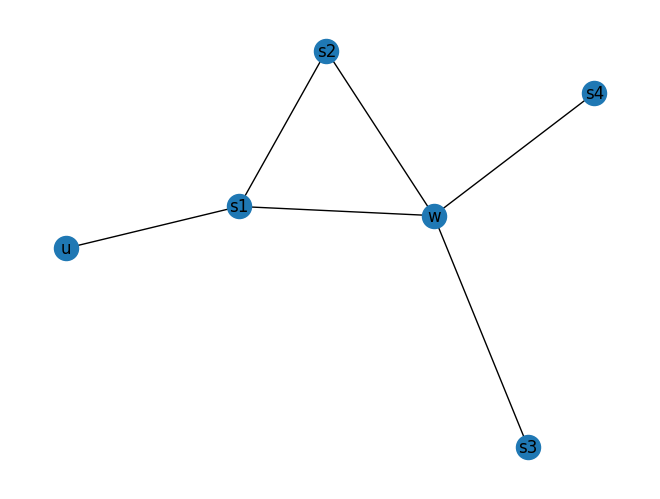

In [32]:
nx.draw(test_G, with_labels = True)

In [37]:

results = {k:0 for k in test_G.neighbors(start_node)}
results

{'s1': 0, 's2': 0, 's3': 0, 's4': 0}

In [41]:
test_G = nx.Graph()
test_G.add_edge('w', 's1')
test_G.add_edge('w', 's2')
test_G.add_edge('w', 's3')
test_G.add_edge('w', 's4')
test_G.add_edge('s1', 's2')
test_G.add_edge('s1', 'u')

sample_num = 10000
start_node = 'w'

results = {k:0 for k in test_G.neighbors(start_node)}
for i in range(sample_num):
    walk = random_walk(test_G, start_node, 1)
    results[walk[-1]]+=1

for k,v in results.items():
    print('{}:{}'.format(k, v/sample_num))

s1:0.2574
s2:0.2454
s3:0.2483
s4:0.2489


### 4. (10 points) SkipGram

SkipGram is a language model that maximizes the cooccurrence probability among the words that appear within
a window w in a sentence. Similarly, we can regard the above sampled random walks as short sentences in NLP. Our goal is to estimate the likelihood of observing vertex $v_i$ given the vertices in the random walk. We introduce a mapping function $ Φ: v ∈ V→R^{|V|×d} $. This mapping $Φ$ represents the latent representation associated with each vertex $v$ in the graph. (In practice, we represent $Φ$ by a $|V|×d$ matrix of free parameters.) The objective then, is to optimize the loss function: $ L=-logPr ({v}_{i} | Φ(v_k)) $

For more details, you can read the original [DeepWalk](http://www.perozzi.net/publications/14_kdd_deepwalk.pdf) paper.

In this part, you are required to implement a simple skipgram model. The class defines the model, whereas the function ***model_training*** describes the training loop of the model.

In [45]:
class skip_gram(torch.nn.Module):
    def __init__(self, node_num, d):
        # The SkipGram model implementation
        super(skip_gram, self).__init__()
        # i-th row of the model.phi corresponds to vector of the i-th node.
        self.phi = nn.Parameter(torch.rand((node_num, d), requires_grad=True))    
        self.phi2 = nn.Parameter(torch.rand((d, node_num), requires_grad=True))
        
    def forward(self, one_hot):
        hidden = torch.matmul(one_hot, self.phi)
        out = torch.matmul(hidden, self.phi2)
        return out
    
def model_train(s_walk, w, node_num, d):
    model = skip_gram(node_num, d)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    
    total_loss = 0
    optimizer.zero_grad()
    for j in range(len(s_walk)):
        for k in range(max(0,j-w), min(j+w, len(s_walk))):
            
            # generate one hot vector
            one_hot = torch.zeros(node_num)
            one_hot[s_walk[j]] = 1
            
            out_hot = torch.zeros(node_num)
            out_hot[s_walk[k]] = 1
            
            
            #### your code here
            # You need to implement both forward and backward propagation via pytorch
            # Forward pass
            output = model.forward(one_hot)
            
            # Calculate loss
            loss = loss_fn(output, out_hot)
            
            total_loss += loss
            
    # Backpropagation
    total_loss.backward()
    optimizer.step()

Below is a test for your function model_train. If your code is correct, the vectors of 'w', 's1', 's2', and 's3' are very close, whereas their vector are much different from the vectors corresponding to 'u' and 's4'.

In [46]:
test_G = nx.Graph()
test_G.add_edge('w', 's1')
test_G.add_edge('w', 's2')
test_G.add_edge('w', 's3')
test_G.add_edge('u', 's4')

w = 3 # window size
l = 6 # walk length
d = 2 # embedding size
node_num = 6
sample_num = 1000
nodes_list = list(test_G.nodes)

test_name2id, test_id2name = tokenize(test_G)
model = skip_gram(node_num, d)

for i in range(sample_num):
    random.shuffle(nodes_list)
    for vi in nodes_list:
        s_walk = random_walk(test_G, vi, l)
        s_walk = [test_name2id[x] for x in s_walk]
        model_train(s_walk, w, node_num, d)

print(test_id2name)
print(model.phi)

{0: 'w', 1: 's1', 2: 's2', 3: 's3', 4: 'u', 5: 's4'}
Parameter containing:
tensor([[0.0749, 0.5761],
        [0.5126, 0.7454],
        [0.7121, 0.7506],
        [0.5736, 0.0795],
        [0.4131, 0.0150],
        [0.2719, 0.1851]], requires_grad=True)


### 5. (20 points) Negative Sampling

However, normalizing the probability across all nodes are expensive. Here we implement the negative sampling strategy to reduce the computation cost. Given $z_v=Φ(v)$, our goal is to maximize the co-occurring probability of nodes u and v, which can be formulated as:
\begin{equation}
P=\sum_{u \in V}\sum_{v \in N_R(u)}\log{\left(\frac{e^{z_u^Tz_v}}{\sum_{n \in V}e^{z_u^Tz_n}}\right)}
\end{equation}
For computational efficiency, the partition function (denominator in the above equation) can be estimated by several negative samples, which can be written as follows:
\begin{equation}
P=\log{\left(\sigma(z_u^Tz_v)\right)} - \sum_{i=1}^k\log{\left(\sigma(z_u^Tz_{n_i})\right)}
\end{equation}
Where $\{n_i\}, 0 \leq i < k$ are the negative samples. 
Please implement the negative sampling function below.

In [53]:
def negative_sampling(G, walk, k, id2name, name2id):
    # Suppose start node of walk is u.Sampling k nodes which are neither on the walk nor adjacent to u.
    
    # G: networkx graph
    # walk: list of node names, a random walk
    # k: number of negative samples
    # id2name: a dictionary with key being node index and value being node name.(refer to previous tokenize function)
    # name2id: a dictionary with key being node name and value being node index.(refer to previous tokenize function)
    
    # You should return a list consists of k node name.
    
    ####your code here
    sample_negs = []
    for _ in range(k):
        while True:
            # Randomly sample a node id from the graph
            neg_node = random.choice(list(id2name.keys()))
            # Check if it is not in the walk and not adjacent to the start node
            if id2name[neg_node] not in walk and neg_node not in G.neighbors(walk[0]):
                sample_negs.append(id2name[neg_node])
                break
    ###

    return sample_negs

Below is a test for function negative sampling. If your implementation is correct, the output should look like: \
['s3', 's4']

In [54]:
test_G = nx.Graph()
test_G.add_edge('w', 's1')
test_G.add_edge('w', 's2')
test_G.add_edge('w', 's3')
test_G.add_edge('w', 's4')
test_G.add_edge('s1', 's2')
test_G.add_edge('s1', 'u')

test_walk=['s2', 's1', 'u']
name2id_test, id2name_test = tokenize(test_G)
neg_nodes = negative_sampling(test_G, test_walk, 10, id2name_test, name2id_test)
neg_nodes = np.unique(neg_nodes)
print(neg_nodes)

['s3' 's4' 'w']


Now we collect data by random walks to form training dataset.

In [55]:
# get data
data = []
num_walks = 100
walk_length = 5
k=5

for walk_iter in tqdm(range(num_walks)):
    nodes = list(G.nodes)
    random.shuffle(nodes)
    for n in nodes:
        w = random_walk(G, n, walk_length)
        nw = negative_sampling(G, w, k=k, id2name=id2name, name2id=name2id)
        x = w + nw
        x = [name2id[i] for i in x]
        pos_labels = np.ones(len(w)-1) # except for start node
        neg_labels = np.zeros(len(nw))
        labels = np.concatenate([pos_labels, neg_labels], axis=0) # walk_length + k
        data.append({'u': x[0], 'vs': x[1:], 'labels': labels})
        
class DW_Dataset(Dataset):
    def __init__(self, data):
        super(DW_Dataset).__init__()
        self.data = data
          
    def __len__(self):
        return len(self.data)    
        
    def __getitem__(self, idx):
        d = self.data[idx]
        return torch.tensor(d['u']).long(), torch.tensor(d['vs']).long(), torch.tensor(d['labels']).float()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 891.22it/s]


## Learn Node Embedding

The final step is to train node embedding. We try to minimize the loss function below:
\begin{equation}
L = -\log{\left(\sigma({z_u}^Tz_v)\right)} + \sum_{i=1}^k\log{\left(\sigma({z_u}^Tz_{n_i})\right)}
\end{equation}
which can be efficiently implemented with ***binary cross entropy(BCE)*** loss. \
Besides, we use ***Stocastic Gradient Descent(SGD)*** to optimize our model.
Please follow the instruction below and implement the code.

### 6. (10 points) Predict Similarity

The forward pass of deepwalk model aims to predict the similarity between two nodes. To be specific, the similarity between node $u$ and $v$ is:
\begin{equation}
\text{Similarity} = {z_u}^Tz_v
\end{equation}
where $z_u$ is the embedding for node $u$.
Please implement the forward pass in deepwalk model.

In [66]:
class DeepWalk(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.embedding = nn.Embedding(num_embeddings=len(G.nodes), embedding_dim=16)
    
    def forward(self, u, vs):
        # Calculate the similarity between node u and a list of nodes vs.
        
        # u: tensor, (batch_size, ). start node
        # vs: tensor,(batch_size, walk_length -1 + k). a list of nodes including nodes within a walk(positive examples) and outside of walk(negative examples).
        
        # You should return a tensor of size (batch_size, len(vs)) with each entry indicates the similarity between u and each v from vs.
        
        
        ### your code here
        # Embed the nodes u and vs
        u_embed = self.embedding(u)
        vs_embed = self.embedding(vs)

        similarity = torch.nn.functional.cosine_similarity(u_embed.unsqueeze(1), vs_embed, dim=2)
        ###

        return similarity

Below is a test for your DeepWalk model. If your implementation is correct, your output should looks like this: \
tensor([[ 3160.,  5080.,  7000.], \
        [ 3160., 15192., 27224.]])

In [67]:
test_model = DeepWalk(test_G)

test_weight = torch.arange(16 * len(test_G.nodes)).reshape(-1, 16).float()
test_model.embedding = nn.Embedding.from_pretrained(test_weight)

u = torch.tensor([0,1]).long()
vs = torch.tensor([[1,2,3], [0,2,4]]).long()
sim = test_model.forward(u, vs)
print(sim)

tensor([[0.9368, 0.9069, 0.8924],
        [0.9368, 0.9970, 0.9917]])


### 7. (20 points) Train Embedding

Now, you're ready to implement a typical model training process using pytorch. Follow the instruction below and train node embedding.

In [69]:
model = DeepWalk(G)
dataset = DW_Dataset(data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=0.001)
num_epochs = 200

def train(num_epochs, model, dataloader, optimizer):
    # Train node embedding. The training mainly consists of the following step:
    

    # 1. Get a batch of data from dataloader.
    # 2. Feed the data to deepwalk model and get similarity between start node u and rest nodes.
    # 3. Compute the binary cross entropy loss between predicted similarity and labels.
    # 4. Backpropagate loss.
    # 5. Update parameters.
    
    # hint:
    # 1. You can use BCELoss from torch.nn(Don't forget the sigmoid part).
    # 2. Above step should be repeated for every batch in dataloader in each epoch. Total epoch is num_epochs.
    
    ### your code here
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with Logits
    sigmoid = nn.Sigmoid()  # Sigmoid activation to convert logits to probabilities

    for epoch in range(num_epochs):  
        for batch in dataloader:
            optimizer.zero_grad()
            u, vs, labels = batch  # Unpack batch data

            # Forward pass
            similarity = model.forward(u, vs)

            # Apply sigmoid to convert logits to probabilities
            probs = sigmoid(similarity)

            # Compute binary cross entropy loss
            loss = criterion(probs, labels)
        
            # Backpropagation
            loss.backward()
            optimizer.step()

    return None
train(num_epochs, model, dataloader, optimizer)

## Visualize Embedding

## Application: Graph Clustering

Now, we can cluster the nodes by their embeddings. We first use k-means to cluster nodes to 6 clusters. Then, we assign color to a node based on its cluster. By looking at whether similar nodes are assigned similar colors, we can learn whether the model successfully put similar nodes to near positions in embedding space. \
If there is no homophily presented in below representation at all, you might have to debug your code. \
You might tune the hyperparameters such as walk length, k to observe different clustering results.

### 8. (10 points)  DeepWalk Embedding Homophily

You don't have to implement any code here. You will get the 10 points if graph homophily is clearly presented in the following visualization. To be specific, there should be at least 4 color clusters to prove your model has learn meaningful embeddings.

/Users/jacob/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


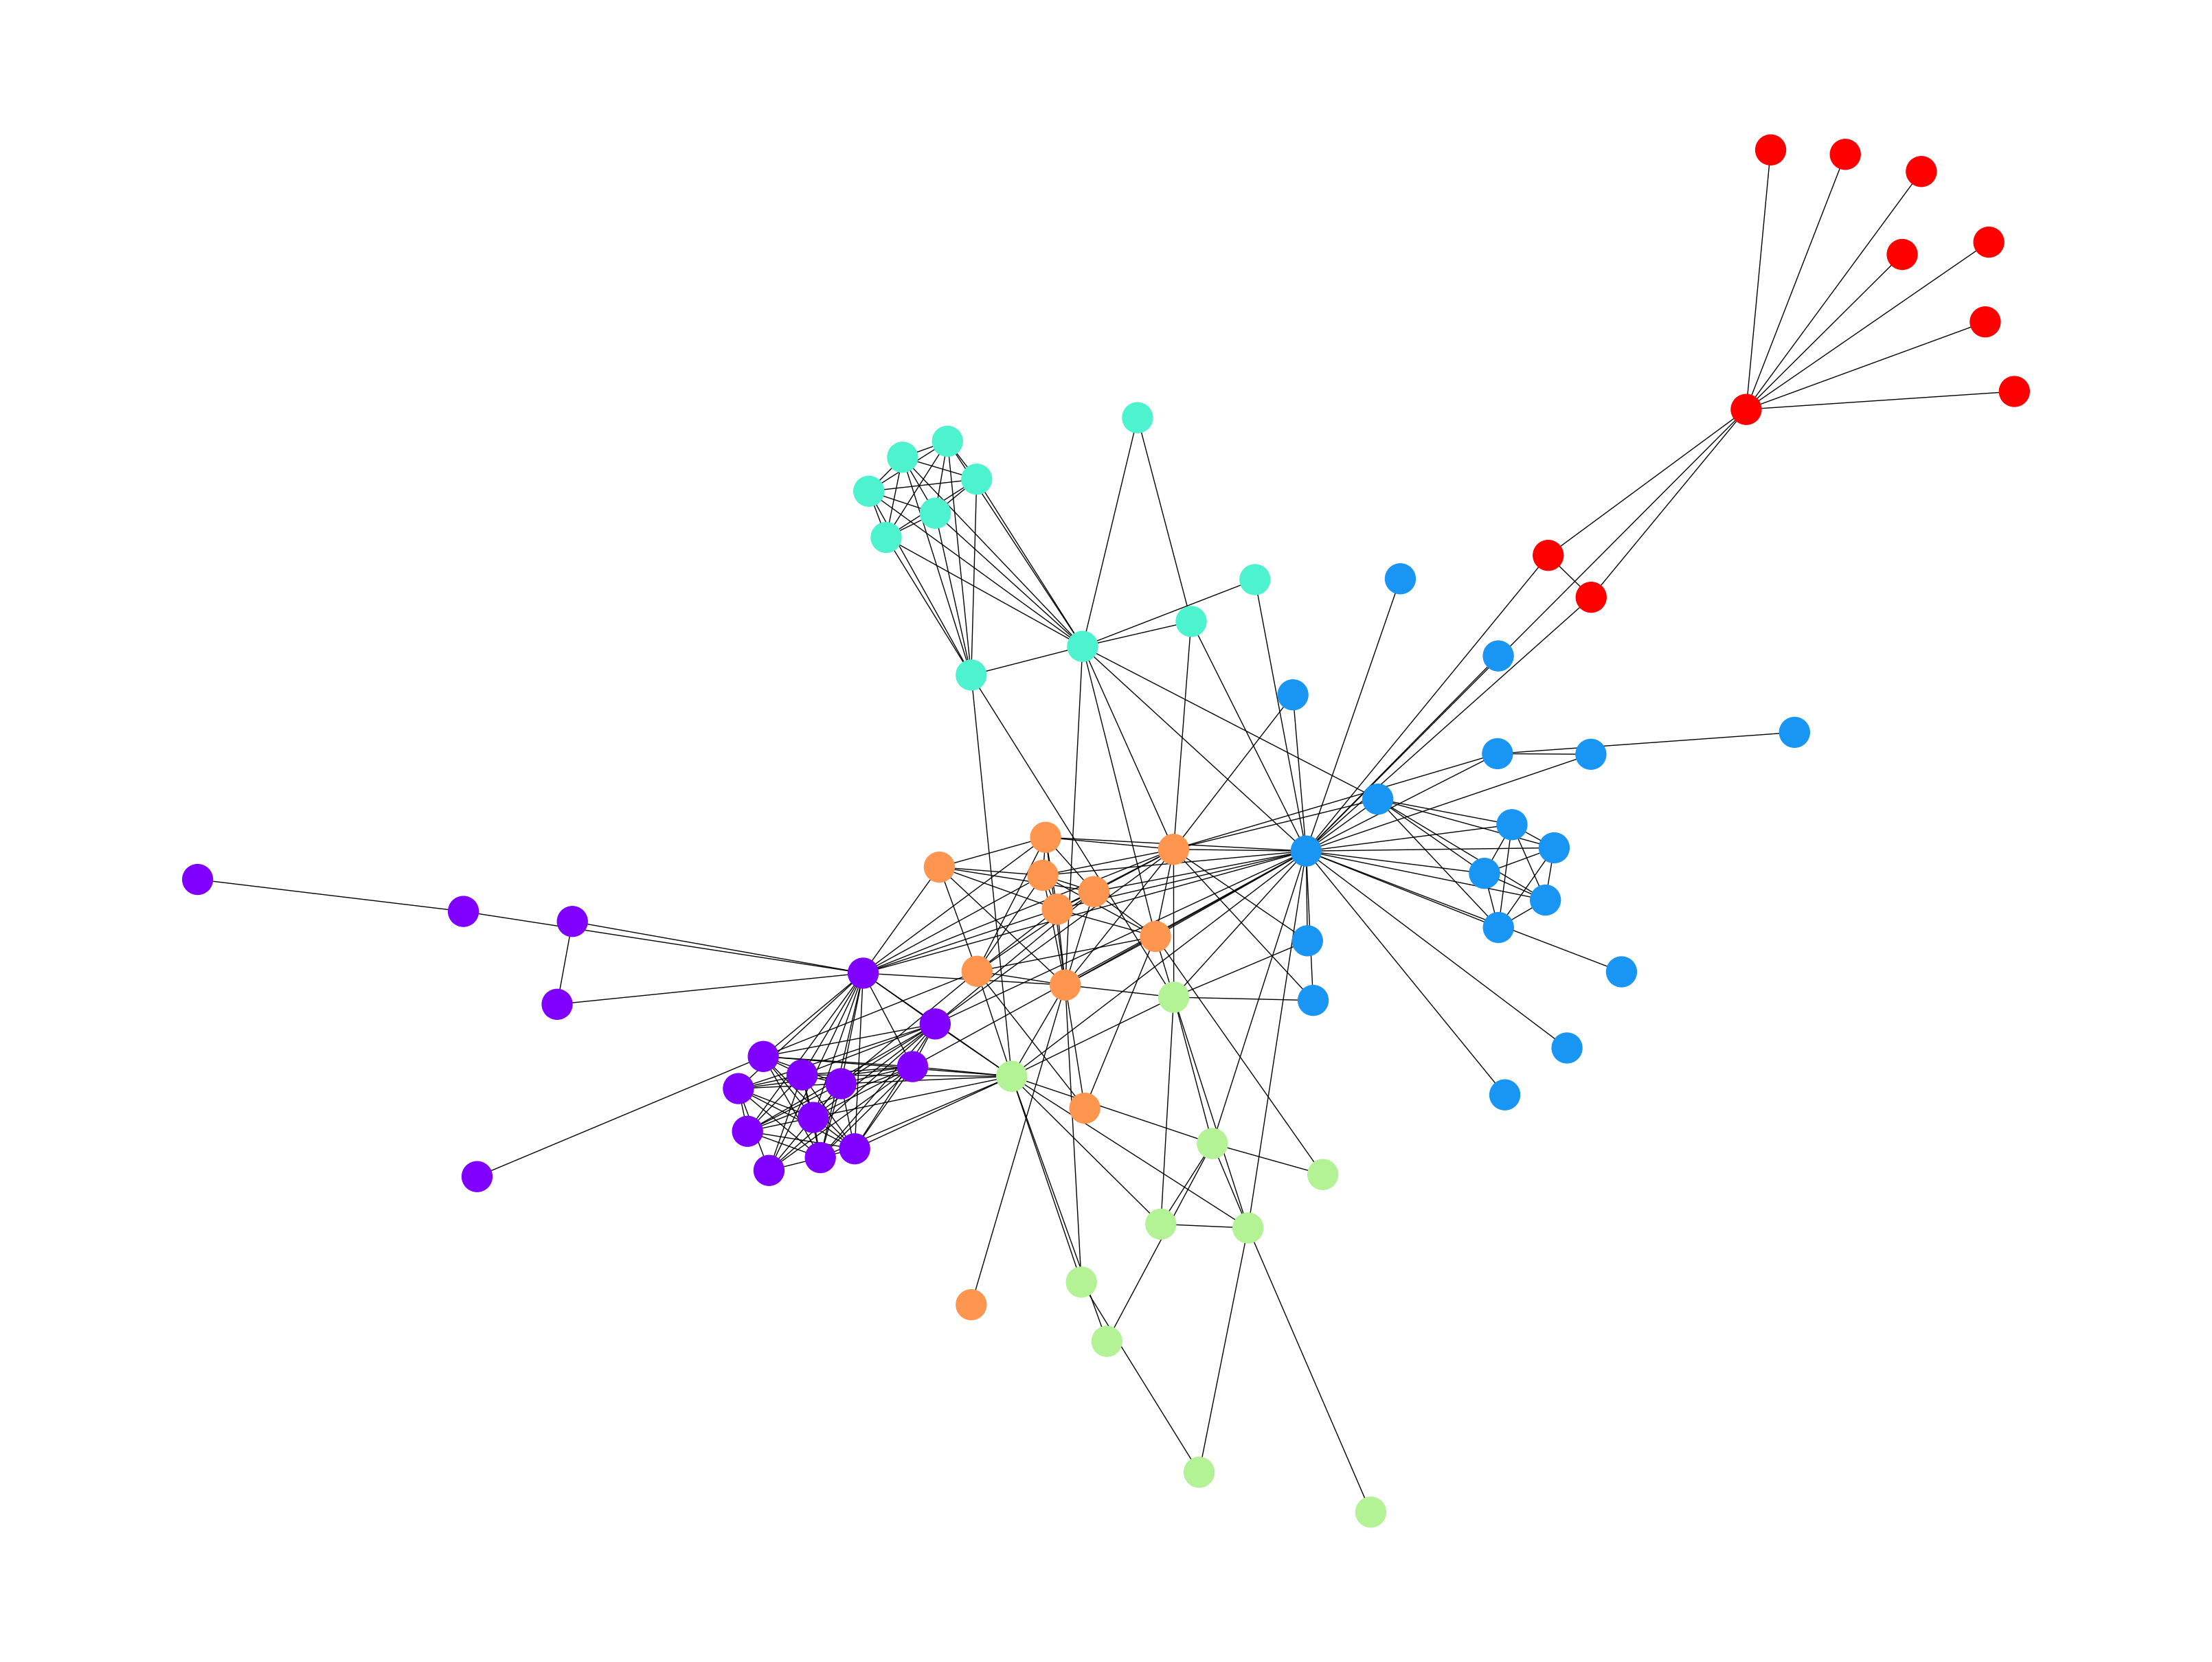

In [70]:
# get k-means clustering for 6 labels
node_embeddings=model.embedding.weight.data
kmeans_cluster = KMeans(n_clusters=6, init='k-means++').fit(node_embeddings)
kmeans_labels = kmeans_cluster.labels_

plt.figure(figsize=(32,24))
nx.draw(G, pos=nx.spring_layout(G, seed=10), node_color=kmeans_labels, node_size=1000, cmap=plt.cm.rainbow)